## Point to Data

In [1]:
# datadir='/Users/josesho/Google Drive/Data+Scripts/Python/CCLAB-PY/ESPRESSO/test-data/Trh-Gal4-Trh-Zal-UAS-GZ-TrpA1'
datadir='/Volumes/NRP-SOD/Espresso-Data/ZAL/Trh-Gal4/Trh-Gal4_UAS_TRPA1'

## Load Libraries

In [2]:
import sys
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm'] = 'Arial'
%matplotlib inline

import seaborn as sns
# For annotating plots later.
from string import ascii_uppercase as alphabet
alphabet_labels=dict( zip(range(0,26), alphabet) )

import bootstrap_contrast as bs
import plot_helpers as pthelp

/Users/josesho/anaconda3/envs/py3.6/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## 1. Read in Data and Munge it

### 1a. Get all CSVs in the datadir.

Each folder should have one complete experiment, with the following CSVs from CRITTA:
1. MetaData_Data_Time_Genotype_Temperature.csv
2. FeedLog_..._.csv
3. FeedStats_..._.csv

In [3]:
folders=np.sort( [f[0] for f in os.walk(datadir)] )[1:] # drop the first output corresponding to hidden file(s).
print(folders)

if len(folders) != 2:
    raise ValueError('There are '+str(len(folders))+ 'subfolders found. There should be exactly 2.')

['/Volumes/NRP-SOD/Espresso-Data/ZAL/Trh-Gal4/Trh-Gal4_UAS_TRPA1/22'
 '/Volumes/NRP-SOD/Espresso-Data/ZAL/Trh-Gal4/Trh-Gal4_UAS_TRPA1/29']


In [4]:
metadata_dict=dict()
feeds_bytemp_dict=dict()

for f in folders:
    subfolder=f
    genotype=subfolder.split('/')[-2]
    temperature=subfolder.split('/')[-1]+'ºC'
    current_key=' '.join([genotype,temperature])
    
    metadata_file=[f for f in os.listdir(subfolder) if f.startswith('MetaData')][0]
    metadata=pd.read_csv(os.path.join(subfolder,metadata_file))
    metadata=metadata.set_index('ID') # turn the ID column into the index.
    metadata_dict[current_key]=metadata
    
    feedlog_file=[f for f in os.listdir(subfolder) if f.startswith('FeedLog')][0]
    feedlog=pd.read_csv(os.path.join(subfolder,feedlog_file))
    # To drop the feed events where `AviFile` is "Null". These events have a `RelativeTime-s` of -0.001.
    feedlog.drop(feedlog[feedlog.AviFile=='Null'].index, inplace=True)

    # The `FlyID` column actually refers to chambers.
    # You have to ADD 1 to match the feedlog FlyID
    # with the corresponding chamber in `metadata`.
    feedlog.FlyID=feedlog.FlyID+1

    # Compile cumsum per chamber into a new DataFrame.
    feeds_df=list()

    for j,c in enumerate( np.sort(feedlog.FlyID.unique()) ):
        chamber=feedlog[feedlog.FlyID==c]
        temp=pd.DataFrame( [chamber['Volume-mm3'], 
                            chamber['RelativeTime-s'],
                            chamber['Duration-ms']] ).T # remember to transpose.
        temp.columns=['FeedVol_µl','RelativeTime_s','FeedDuration_ms'] # 1 mm3 = 1µl
        temp.reset_index(inplace=True)
        temp.drop('index',axis=1,inplace=True)

        # Add columns.
        temp['chamberID']=np.repeat(c, len(chamber))
        temp['FeedVol_nl']=temp['FeedVol_µl']*1000
        temp['FeedSpeed_nl/s']=temp['FeedVol_nl']/(temp['FeedDuration_ms']/1000)
        temp['Temperature']=np.repeat(metadata.loc[c,'Temperature'], len(chamber))
        temp['Sex']=np.repeat(metadata.loc[c,'Sex'], len(chamber))
        temp['FlyCount']=np.repeat(metadata.loc[c,'#Flies'], len(chamber))
        temp['CountAsFeed']=np.repeat(1, len(chamber)) # This columns will be used track feed counts later.

        geno=metadata.loc[c,'Genotype']
        if geno.startswith('W1118') or geno.startswith('w1118'):
            expt_status='Sibling Controls'
        else:
            expt_status='Offspring'
        temp['ExptStatus']=np.repeat(expt_status, len(chamber))
        # Place genotype as last column for easy access in next plotting cell.
        temp['Genotype']=np.repeat(geno, len(chamber))

        # Define 2 padrows that will ensure all chamber feedlogs fully capture the entire 6-hour duration.
        padrows=pd.DataFrame( [[0,0.5, # 0.5 second.
                              0,c,0,0,
                              metadata.loc[c,'Temperature'],metadata.loc[c,'Sex'],metadata.loc[c,'#Flies'],
                              0,expt_status,geno],
                              [0,21891, # 6 hrs, 5 min, 1 sec in seconds.
                               0,c,0,0,
                               metadata.loc[c,'Temperature'],metadata.loc[c,'Sex'],metadata.loc[c,'#Flies'],
                               0,expt_status,geno]] )
        padrows.columns=temp.columns
        # Add the row to `temp`.
        temp=temp.append(padrows,ignore_index=True) # there is no `inplace` argument for append.

        # Convert `RelativeTime_s` to DateTime object.
        temp['RelativeTime_s']=pd.to_datetime(temp['RelativeTime_s'],unit='s')

        # Save the `temp` DataFrame to the `feeds_df` list.
        feeds_df.append(temp)

    # Concatenate all the individual cumsums.
    feeds_df=pd.concat(feeds_df)
    
    # Reset index.
    feeds_df.reset_index(inplace=True)
    feeds_df.drop('index',axis=1,inplace=True)
    # Make sure ExptStatus is categorical.
    feeds_df['ExptStatus']=feeds_df.loc[:,'ExptStatus'].astype('category')
    # Set the order. 
    feeds_df['ExptStatus']=feeds_df.loc[:,'ExptStatus'].cat.set_categories(['Sibling Controls', 'Offspring'],ordered=True)
    # Add to dictionary.
    feeds_bytemp_dict[current_key]=feeds_df
    
    # identify chambers that did not have any feed events, and are likely to be empty.
    empty_chambers=list( set(metadata.index) - set(feeds_df.chamberID.unique()) )
    print('\n'+current_key)
    print('Chamber(s) with 0 feed events: ',empty_chambers)
    # Next, get fly count.
    # flycount=metadata.drop(empty_chambers).groupby('Genotype').sum()['#Flies']
    print('\nTotal Fly Count by genotype')
    flycount=metadata.groupby('Genotype').sum()['#Flies']
    print(flycount)
    
expt_groups=np.sort(list(metadata_dict.keys()))


Trh-Gal4_UAS_TRPA1 22ºC
Chamber(s) with 0 feed events:  []

Total Fly Count by genotype
Genotype
Trh-Gal4>UAS-TrpA1    40
W1118;Trh-Gal4        40
W1118;UAS-TrpA1       40
Name: #Flies, dtype: int64

Trh-Gal4_UAS_TRPA1 29ºC
Chamber(s) with 0 feed events:  []

Total Fly Count by genotype
Genotype
Trh-Gal4>UAS-TrpA1    40
W1118;Trh-Gal4        40
W1118;UAS-TrpA1       41
Name: #Flies, dtype: int64


### 1b. Create Palette

In [5]:
# First, check that all the genotypes across the metadata files are the same.
if (metadata_dict[expt_groups[0]].Genotype.unique() == metadata_dict[expt_groups[1]].Genotype.unique()).any():
    # Create metadata palette.
    genotype_palette=dict( zip( metadata_dict[expt_groups[0]].Genotype.unique(), 
                               ['royalblue','deepskyblue','red'] ) 
                         )
    desat_list=[]
    for k in genotype_palette.keys():
        desat_list.append(sns.desaturate(genotype_palette[k],0.5))
    genotype_palette_desat=dict( zip( metadata_dict[expt_groups[0]].Genotype.unique(), desat_list ) )
    print(genotype_palette, genotype_palette_desat)
    
else:
    raise ValueError(str(metadata_dict[expt_groups[0]].Genotype.unique())+' are not equal to '+str(metadata_dict[expt_groups[1]].Genotype.unique()))    

{'W1118;Trh-Gal4': 'royalblue', 'W1118;UAS-TrpA1': 'deepskyblue', 'Trh-Gal4>UAS-TrpA1': 'red'} {'W1118;Trh-Gal4': (0.41176470588235303, 0.49019607843137253, 0.7254901960784312), 'W1118;UAS-TrpA1': (0.25, 0.6245098039215686, 0.75), 'Trh-Gal4>UAS-TrpA1': (0.75, 0.25, 0.25)}


## 2. Cumulative Volume 

In [6]:
expt_groups

array(['Trh-Gal4_UAS_TRPA1 22ºC', 'Trh-Gal4_UAS_TRPA1 29ºC'],
      dtype='<U23')

In [7]:
fig_label_kwargs=dict(xy=(-0.3,1.01),
                      xycoords='axes fraction',
                      fontsize=20,
                      fontweight='bold',
                      clip_on=False)
sns.set(context='poster',style='ticks',font_scale=1.4)

/Users/josesho/anaconda3/envs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


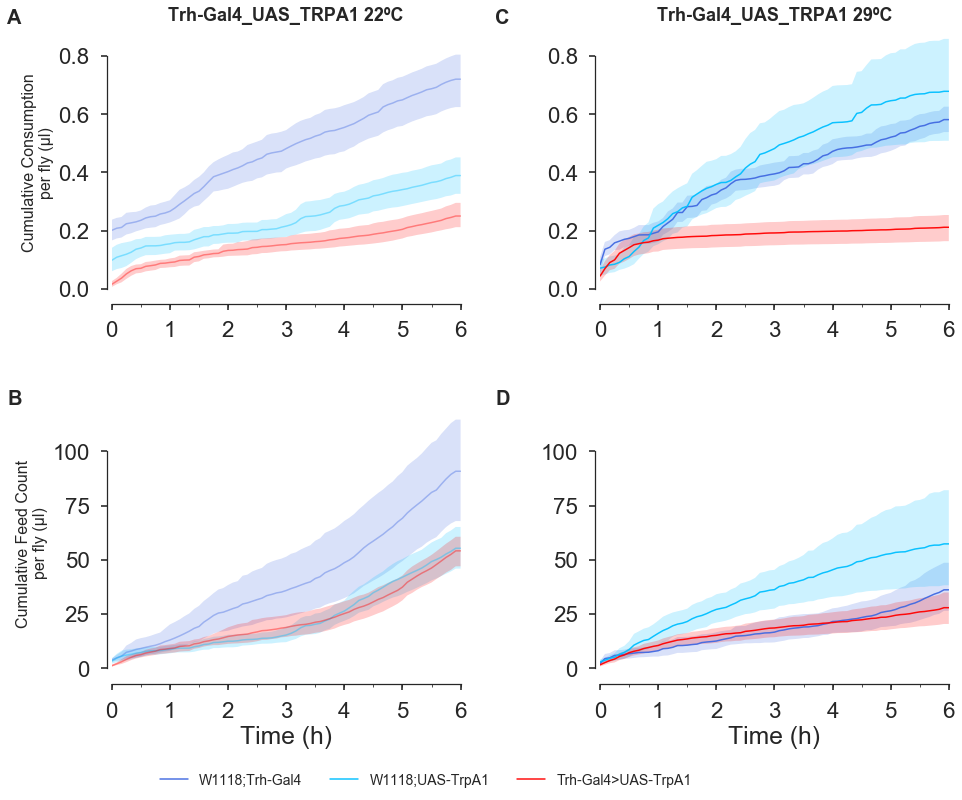

In [8]:
feeds_resamp_cumsum_dict=dict()
# Initialise figure.
f,ax_arr=plt.subplots(nrows=2,
                      ncols=2,
                      figsize=(15,12),
                      sharex=True,
                      gridspec_kw=dict(wspace=0.4, # width-wise spacing.
                                       hspace=0.4) # height-wise spacing.
                     )

for col,k in enumerate(expt_groups):
    df=feeds_bytemp_dict[k]
    # Create the `groupby.resamp` pandas object
    feeds_df_resamp=df.groupby(['ExptStatus','Genotype','chamberID']).resample('5min',on='RelativeTime_s')
    feeds_df_resamp_sum=feeds_df_resamp.sum()

    # Drop extraneous columns.
    feeds_df_resamp_sum.drop(['chamberID','Temperature','FlyCount'],
                         axis=1,inplace=True)
    # Calculate cumulative sum.
    feeds_df_resamp_cumsum=feeds_df_resamp_sum.groupby('chamberID').cumsum().fillna(method='pad')
    # Re-name the columns.
    feeds_df_resamp_cumsum.columns='Cumul'+feeds_df_resamp_sum.columns
    # 'Unstack' the DataFrame to facilitate plotting.
    # See https://stackoverflow.com/questions/22779516/unstack-multiindex-dataframe-to-flat-data-frame-in-pandas
    feeds_df_resamp_cumsum=pd.DataFrame(feeds_df_resamp_cumsum.to_records())
    # Add time column (in minutes) to facilitate plotting.
    feeds_df_resamp_cumsum['RelativeTime_min']=feeds_df_resamp_cumsum.RelativeTime_s.dt.hour*60 + \
    feeds_df_resamp_cumsum.RelativeTime_s.dt.minute
    # Divide the cumulative columns by the respective number of flies in each chamber.
    metadata=metadata_dict[k]
    for chamber in feeds_df_resamp_cumsum.chamberID.unique():
        flycount=metadata.loc[chamber,'#Flies']
        idx=np.where(feeds_df_resamp_cumsum.chamberID==chamber)[0]
        for c in ['CumulFeedVol_µl','CumulCountAsFeed']:
            feeds_df_resamp_cumsum.loc[idx,c]=feeds_df_resamp_cumsum.loc[idx,c]/flycount
    # Save to dictionary.
    feeds_resamp_cumsum_dict[k]=feeds_df_resamp_cumsum
    
    if '22' in k:
#         pal=genotype_palette_desat
        temp_alpha=0.4
    elif '29' in k:
#         pal=genotype_palette
        temp_alpha=0.95
    else:
        raise ValueError('Specified Temp is neither 22ºC not 29ºC.')
    
    for row,ycols in enumerate(['CumulFeedVol_µl','CumulCountAsFeed']):
        axplot=ax_arr[row,col]
        sns.tsplot(data=feeds_df_resamp_cumsum,ci=95,ax=axplot,
                   time='RelativeTime_min',unit='chamberID',
                   condition='Genotype',value=ycols,
                   color=genotype_palette,
                   alpha=temp_alpha,
                   linewidth=1.5)
        axplot.xaxis.set_major_locator( tk.MultipleLocator(base=60) )
        axplot.xaxis.set_minor_locator( tk.MultipleLocator(base=30) )
    
        if row==0:
            axplot.set_title(k,fontsize=18,fontweight='bold')

# equalize ylims across each row.
for rownum in [0,np.shape(ax_arr)[0]-1]:
    ymins=list()
    ymaxs=list()
    for ax in ax_arr[rownum, :]:
        ymin=ax.get_ylim()[0]
        ymax=ax.get_ylim()[1]
        ymins.append(ymin)
        ymaxs.append(ymax)
    for ax in ax_arr[rownum, :]:
        ax.set_ylim(np.min(ymins),
                   np.max(ymaxs))
        
for j,ax in enumerate(ax_arr[0, :]): # First row.
    ax.legend().set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.annotate(s=str( alphabet_labels[j*2] ),**fig_label_kwargs)
    sns.despine(ax=ax,trim=True,offset=5)

for j,ax in enumerate(ax_arr[1, :]): # Second row.
    ax.set_ylabel('')
    ax.legend(loc='upper center',bbox_to_anchor=(-0.5,-0.3), # xycoords
              ncol=3,fontsize=14)
    ax.set_xlabel('Time (h)')
    newlabels=[str(int(int(t)/60)) for t in ax.xaxis.get_ticklocs(minor=False)]
    ax.set_xticklabels(newlabels)
    ax.annotate(s=str( alphabet_labels[(j*2)+1] ),**fig_label_kwargs )
    sns.despine(ax=ax,trim=True,offset=5,)

ax_arr[0,0].set_ylabel('Cumulative Consumption\nper fly (µl)', fontsize=16)
ax_arr[1,0].set_ylabel('Cumulative Feed Count\nper fly (µl)', fontsize=16)
ax_arr[1,0].legend().set_visible(False)

for j, a in enumerate(ax_arr.flat): 
    sns.despine(ax=a,trim=True)
plt.show()

## 3. Feed Volume and Feed Speed

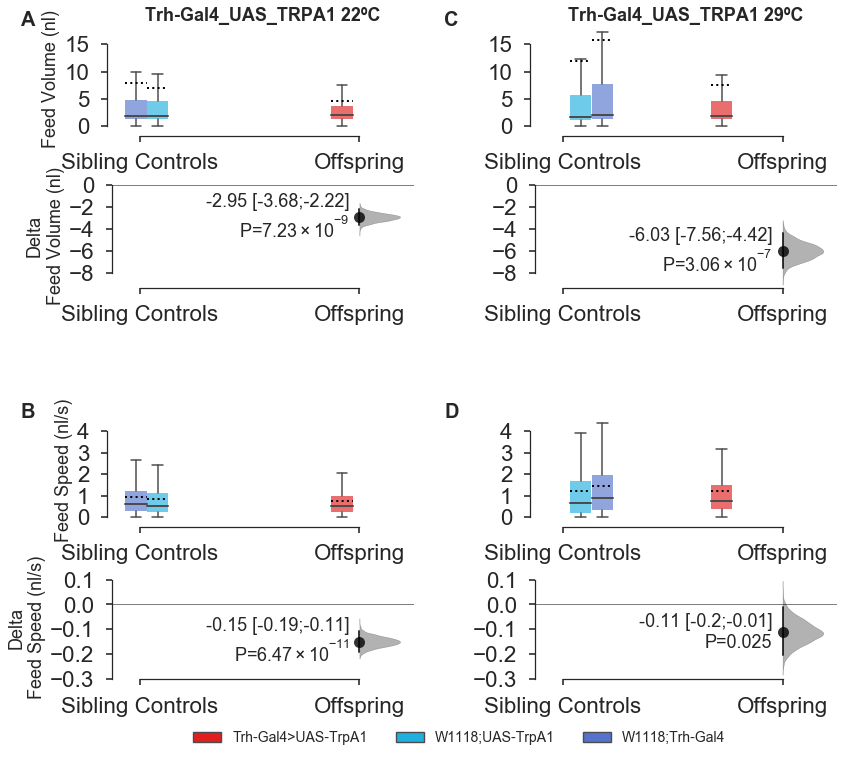

In [9]:
boxplot_args=dict(hue='Genotype',
                  palette=genotype_palette,
                  showmeans=True,
                  meanline=True,
                  showfliers=False,
                  width=0.4,
                  meanprops=dict(linewidth=2,color='k',linestyle=':'),
                  medianprops=dict(linewidth=2,),
                  boxprops=dict(linewidth=0,alpha=0.65),
                  capprops=dict(linewidth=1.5),
                  whiskerprops=dict(linewidth=1.5),
                  flierprops=dict(markersize=4,markerfacecolor='grey',
                                  alpha=0.5,marker='o')
                 )

axes_divider_args=dict(position="bottom", 
                 size="100%", 
                 pad=0.75)

### Set xticks positions.
xticks=[-0.11,1.24]

### Initialise figure.
f,ax_arr=plt.subplots(nrows=2,
                      ncols=2,
                      figsize=(13,12),
                      sharex=True,
                      gridspec_kw=dict(wspace=0.4, # width-wise spacing.
                                       hspace=0.5) # height-wise spacing.
                     )
contrast_feed_vol_list=[]
contrast_feed_rate_list=[]

### Make plot.
for col,k in enumerate(expt_groups):
    df=feeds_bytemp_dict[k]
    # Name axes for easy reference.
    boxplot_feed_vol=ax_arr[0,col]
    boxplot_feed_rate=ax_arr[1,col]
    
    ## Boxplot Feed Volume
    sns.boxplot(data=df,x='ExptStatus',y='FeedVol_nl',
                ax=boxplot_feed_vol,**boxplot_args
               )
    boxplot_feed_vol.set_title(k,fontsize=18,fontweight='bold')
    boxplot_feed_vol.set_xlabel('')
    ## Contrast Plot Feed Volume
    divider=make_axes_locatable(boxplot_feed_vol)
    contrast_feed_vol=divider.append_axes(sharex=boxplot_feed_vol,**axes_divider_args)
    # Compute boostraps.
    fv_boots=bs.bootstrap(x1=df[df.ExptStatus=='Sibling Controls'].loc[:,'FeedVol_nl'],
                          x2=df[df.ExptStatus=='Offspring'].loc[:,'FeedVol_nl'])
    # Plot half-violin boostraps.
    v1=contrast_feed_vol.violinplot(fv_boots.stat_array, [xticks[1]], 
                                 showextrema=False, showmeans=False, widths=0.5)
    bs.halfviolin(v1)
    # Plot mean and ci.
    pthelp.meanci(fv_boots.summary, fv_boots.bca_ci_low, fv_boots.bca_ci_high, xticks[1], 
                  ax=contrast_feed_vol, size=11, lw=1.9)
    # Format the pvalue.
    if fv_boots.pvalue_2samp_ind_ttest<1e-3:
        pval=pthelp.sci_nota(fv_boots.pvalue_2samp_ind_ttest)
    else:
        pval=np.round(fv_boots.pvalue_2samp_ind_ttest,3)
    # Annotate delta, 95CI, and p-value.
    annot_text=str( np.round(fv_boots.summary,2) )+\
    ' ['+str( np.round(fv_boots.bca_ci_low,2) )+\
    ';'+str( np.round(fv_boots.bca_ci_high,2) )+\
    ']\nP='+str( pval )
    contrast_feed_vol.annotate(annot_text, 
                               xy=(xticks[1]*0.95, fv_boots.summary),
                               fontsize=18,
                               horizontalalignment='right',
                               verticalalignment='center'
                              )
    # Only add ylabels if these are the leftmost axes.
    if col==0:
        boxplot_feed_vol.set_ylabel('Feed Volume (nl)',fontsize=18)
        contrast_feed_vol.set_ylabel('Delta\nFeed Volume (nl)',fontsize=18)
    else:
        boxplot_feed_vol.set_ylabel('')
    # Save to list.
    contrast_feed_vol_list.append(contrast_feed_vol)
    
    ## Boxplot Feed Rate
    sns.boxplot(data=df,x='ExptStatus',y='FeedSpeed_nl/s',
                ax=boxplot_feed_rate,**boxplot_args
               )
    boxplot_feed_rate.set_xlabel('')
    ## Contrast Plot Feed Rate.
    divider=make_axes_locatable(boxplot_feed_rate)
    contrast_feed_rate=divider.append_axes(sharex=boxplot_feed_rate,**axes_divider_args)
    # Compute boostraps.
    fr_boots=bs.bootstrap(x1=df[df.ExptStatus=='Sibling Controls'].loc[:,'FeedSpeed_nl/s'],
                          x2=df[df.ExptStatus=='Offspring'].loc[:,'FeedSpeed_nl/s'])
    # Plot half-violin boostraps.
    v2=contrast_feed_rate.violinplot(fr_boots.stat_array, [xticks[1]], 
                                 showextrema=False, showmeans=False, widths=0.5)
    bs.halfviolin(v2)
    # Plot mean and ci.
    pthelp.meanci(fr_boots.summary, fr_boots.bca_ci_low, fr_boots.bca_ci_high, xticks[1], 
                  ax=contrast_feed_rate, size=11, lw=1.9)
    # Format the pvalue.
    if fr_boots.pvalue_2samp_ind_ttest<1e-3:
        pval=pthelp.sci_nota(fr_boots.pvalue_2samp_ind_ttest)
    else:
        pval=np.round(fr_boots.pvalue_2samp_ind_ttest,3)
    # Annotate delta, 95CI, and p-value.
    annot_text=str( np.round(fr_boots.summary,2) )+\
    ' ['+str( np.round(fr_boots.bca_ci_low,2) )+\
    ';'+str( np.round(fr_boots.bca_ci_high,2) )+\
    ']\nP='+str( pval )
    contrast_feed_rate.annotate(annot_text, 
                               xy=(xticks[1]*0.95, fr_boots.summary),
                               fontsize=18,
                               horizontalalignment='right',
                               verticalalignment='center'
                              )
    # Only add ylabels if these are the leftmost axes.
    if col==0:
        boxplot_feed_rate.set_ylabel('Feed Speed (nl/s)',fontsize=18)
        contrast_feed_rate.set_ylabel('Delta\nFeed Speed (nl/s)',fontsize=18)
    else:
        boxplot_feed_rate.set_ylabel('')
    contrast_feed_rate_list.append(contrast_feed_rate)
    
### Aesthetic tweaks.
# equalize ylims across each row, first for the boxplot axes.
for rownum in [0,np.shape(ax_arr)[0]-1]:
    pthelp.normalize_ylims(ax_arr[rownum, :])
# Now for the feed vol contrasts.
pthelp.normalize_ylims(contrast_feed_vol_list,include_zero=True,draw_zero_line=True)
# And now for the feed rate contrasts.
pthelp.normalize_ylims(contrast_feed_rate_list,include_zero=True,draw_zero_line=True)

for ax in ax_arr.flat:
    ax.set_xticks(xticks) # tweak the position of the xtick labels.
    sns.despine(ax=ax,trim=True,offset=5)

# Make sure xticks in contrast plots line up with the boxplot xticks.
for axes_list in [contrast_feed_vol_list,
                  contrast_feed_rate_list]:
    for ax in axes_list:
        ax.set_xticks(xticks)
        sns.despine(ax=ax,trim=True)
    
for j,ax in enumerate(ax_arr[0, :]): # First row.
    ax.legend().set_visible(False)
    ax.annotate(s=str( alphabet_labels[j*2] ),**fig_label_kwargs)

for j,ax in enumerate(ax_arr[1, :]): # Second row.
    ax.legend(loc='upper center',bbox_to_anchor=(-0.25,-1.9), # xycoords
              ncol=3,fontsize=14)
    ax.annotate(s=str( alphabet_labels[(j*2)+1] ),**fig_label_kwargs )
    
ax_arr[1,0].legend().set_visible(False)
plt.show()